In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import rasterio as rio
import pysal.viz.mapclassify as mc
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from rasterio.plot import show
from rasterstats import zonal_stats
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point

# data links

Child and infant Malaria mortality_rate_data = https://ourworldindata.org/child-mortality

Malaria prevalence = https://malariaatlas.org/explorer/#/

Country_boundaries = https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip

In [2]:
#import and read files

#countries data
countries = gpd.read_file("ne_50m_admin_0_countries.shp")

#children under 10 years Malaria prevalence raster data
malaria_prevalence = rio.open('2020_GBD2019_Global_PfPR_2019.tif')

#Children under 10 mortality rate from Malaria
moratlity_rate = pd.read_csv('child-mortality_final.csv', encoding='latin1')

<AxesSubplot:>

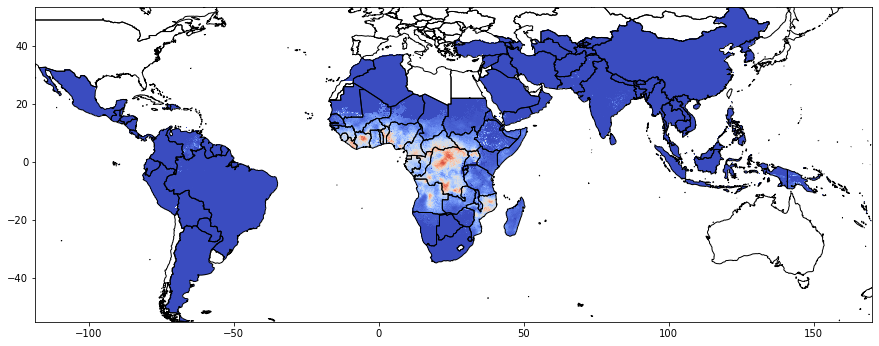

In [3]:
#plot layers
fig, ax = plt.subplots(1, figsize=(15,15))

countries.plot(ax=ax, facecolor='None');

show(malaria_prevalence, cmap='coolwarm', interpolation='none', ax=ax)

In [4]:
# zonal statistics
zs = zonal_stats("ne_50m_admin_0_countries.shp", '2020_GBD2019_Global_PfPR_2019.tif',stats=['sum','count'])

In [5]:
zone_stats_df = pd.DataFrame(zs)

In [6]:
zone_stats_df.rename(columns={'sum':'malaria_prevalence'}, inplace=True)

In [7]:
malaria_prevalence = pd.concat([countries, zone_stats_df], axis=1)

In [8]:
#calculate mortality centroid
death_countries_merged = countries.merge(moratlity_rate, left_on='SOVEREIGNT', right_on='location_name')

# change the geometry from polygon to point
death_countries_merged['geometry'] = death_countries_merged['geometry'].to_crs(3857).centroid.to_crs(4326)

In [9]:
# mortality rate standardization
def rate(row):
    rate_ =row.val*400
    return rate_

death_countries_merged['rate'] = death_countries_merged.apply(rate, axis=1)

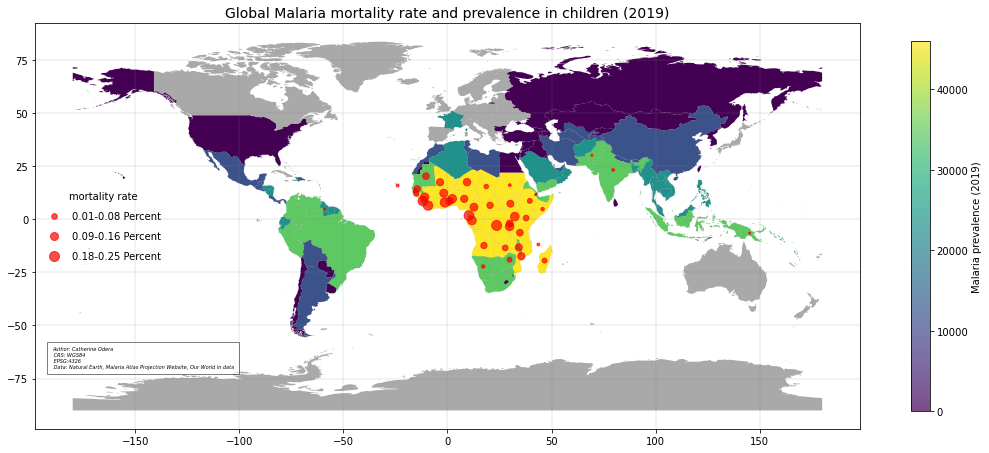

In [10]:
# classification of global malaria prevalence
fig, ax_map = plt.subplots(1, figsize=(15,15))
malaria_prevalence.plot(column="malaria_prevalence", ax=ax_map, linewidth=0.03, cmap="viridis", scheme="quantiles", k=5, alpha=1, legend = True, missing_kwds={'color': 'darkgrey'},edgecolor="k")
death_countries_merged.plot(ax=ax_map, markersize = death_countries_merged['rate'],alpha=0.7, color="red");

# malaria mortality legend 
for a in [0.08, 0.16, 0.25]:
    plt.scatter([], [], c='r', alpha=0.7, s=a*400,
                label=str('%.2f' %(a-0.07)) + "-"+ str(a) +' '+ 'Percent')

plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='center left', title='mortality rate');

# Adding annotation on the plot.
ax_map.text(-190, -70, 'Author: Catherine Odera \n CRS: WGS84 \n EPSG:4326 \n Data: Natural Earth, Malaria Atlas Projection Website, Our World in data', style='italic',fontsize=5, bbox={
        'facecolor': 'white', 'alpha': 0.5, 'pad': 5})

#create colorbar 
plt.colorbar(label='Malaria prevalence (2019)', shrink=0.35)
plt.clim(0, 46000)

# Add title and grid
plt.title("Global Malaria mortality rate and prevalence in children (2019)", size = 14)
plt.tight_layout()
plt.grid(True, color = "grey", linewidth = "0.2")
plt.savefig("Malaria.png", facecolor = 'w', dpi=400)

In [11]:
# Data Query
# Country with minimum mortality rate
min_mortality= death_countries_merged.loc[death_countries_merged['rate'] == min(death_countries_merged["rate"])]

In [12]:
minimum_mortality_intersects = countries[countries.intersects(min_mortality.iloc[1].geometry)]

In [13]:
minimum_mortality_countries=[]
for i in range(5):
    try:
        minimum_mortality_intersects = countries[countries.intersects(min_mortality.iloc[i].geometry)]
        minimum_mortality_countries.append(minimum_mortality_intersects['SOVEREIGNT'].to_list()[0])
    except (IndexError, ValueError):
        pass

In [14]:
print("The countries with the least number of children under 10 Malaria mortality rate of 0.01% are: {}".format(minimum_mortality_countries))

The countries with the least number of children under 10 Malaria mortality rate of 0.01% are: ['Yemen', 'Uzbekistan', 'Uruguay']


In [15]:
# Country with maximum mortality rate
max_mortality= death_countries_merged.loc[death_countries_merged['rate'] == max(death_countries_merged["rate"])]

In [16]:
maximum_mortality_intersects = countries[ countries.intersects(max_mortality.iloc[0].geometry)]

In [17]:
maximum_mortality_countries = maximum_mortality_intersects['SOVEREIGNT'].to_list()

In [18]:
print("The country with the highest number of children under 10 Malaria mortality rate of 0.25% is: {}".format(maximum_mortality_countries))

The country with the highest number of children under 10 Malaria mortality rate of 0.25% is: ['Democratic Republic of the Congo']


In [19]:
malaria_prevalence['malaria_prevalence'] = malaria_prevalence['malaria_prevalence'].replace(np.nan, 0)

In [20]:
# interactive map
import geopandas as gpd

import folium

from fiona.crs import from_epsg

from shapely.geometry import LineString, MultiLineString, Point, MultiPolygon

In [21]:
# Make a selection 
death_countries_merged = death_countries_merged.loc[(death_countries_merged['rate'] > 0)]
death_countries_merged['rate'] = death_countries_merged['rate']/400

# Create a Geo-id
malaria_prevalence['geoid'] = malaria_prevalence.index.astype(str)
death_countries_merged['geoid'] = death_countries_merged.index.astype(str)

C:\Users\USER\miniconda3\envs\geopy2021\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [22]:
malaria_prevalence = malaria_prevalence[['geoid','SOVEREIGNT', 'malaria_prevalence', 'geometry']]

death_countries_merged = death_countries_merged[['geoid','rate','SOVEREIGNT','geometry']]

In [23]:
 # convert the dataframe to geojson
malaria_prevalences_jsontxt = malaria_prevalence.to_json()

death_countries_mergeds_jsontxt = death_countries_merged.to_json()

In [24]:
# Create a Map instance
m = folium.Map(location=[100, 0], zoom_start=1.5)

In [25]:
classifier = mc.Quantiles.make(k=5)

malaria_prevalence['prevalence_classes'] = malaria_prevalence[['malaria_prevalence']].apply(classifier)

choropleth = folium.Choropleth(
  geo_data=malaria_prevalences_jsontxt,
  data=malaria_prevalence,
  columns=['geoid', 'prevalence_classes'],
  key_on="feature.id",
  fill_opacity=0.8,
  line_opacity=0.2,
  line_color='white',
  line_weight=0,
  legend_name='Global Malaria prevalence in childern(2019)',
  name='Malaria mortality',
  highlight=True,
  fill_color='YlOrRd'
  ).add_to(m)
folium.LayerControl(collapsed=True).add_to(m)

# Display Region Label
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['SOVEREIGNT'], labels=False)
)

C:\Users\USER\miniconda3\envs\geopy2021\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\USER\miniconda3\envs\geopy2021\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
C:\Users\USER\miniconda3\envs\geopy2021\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [26]:
from folium.plugins import MarkerCluster

In [36]:
def getPoints(row, geom):
    """Returns coordinate pair tuples for the point ('lat', 'lon') of a Point geometry"""
    if isinstance(row[geom], Point):
        return (row[geom].y, row[geom].x)
    else:
        return ()

In [37]:
# Calculate x and y coordinates of the points
death_countries_merged['points_tuple'] = death_countries_merged.apply(getPoints, geom='geometry', axis=1)  

In [44]:
latlon = [[tup[0], tup[1]] for tup in death_countries_merged['points_tuple'].tolist()]
for idx, mortality in death_countries_merged.iterrows():
    my_string = 'mortality rate {}%, {}'.format(mortality['rate'],mortality['SOVEREIGNT'])
    folium.CircleMarker(location=mortality['points_tuple'], popup=my_string, color="yellow",fill=True,fill_color="yellow",radius=mortality['rate']*20).add_to(m)

In [45]:
m

In [31]:
outfp = "product/Malaria_in_children_map.html"

In [32]:
m.save(outfp)